# Christelle Fuzzy


In [62]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import BertTokenizer
import skfuzzy as fuzz
from sklearn.utils.class_weight import compute_class_weight

# Download NLTK resources
nltk.download('wordnet')
nltk.download('stopwords')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Chris\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Chris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [63]:
# Load data
malta_loc_18 = '../data/Malta-Budget-2018-dataset-v1.csv'
malta_loc_19 = '../data/Malta-Budget-2019-dataset-v1.csv'
malta_loc_20 = '../data/Malta-Budget-2020-dataset-v1.csv'

malta_data_18 = pd.read_csv(malta_loc_18)
malta_data_19 = pd.read_csv(malta_loc_19)
malta_data_20 = pd.read_csv(malta_loc_20)

# Combine all three years datasets
malta_data_19 = malta_data_19.rename(columns={'Off-topic ':'Off-topic'})
combined_data = pd.concat([malta_data_18, malta_data_19, malta_data_20], ignore_index=True)

In [64]:
# Preprocessing
def remove_special_characters(text):
    pattern = re.compile(r'[^a-zA-Z\s]')
    return pattern.sub('', text)

processed_data = combined_data.dropna(subset=['Online Post Text'])
processed_data = processed_data.drop(['Twitter ID', 'Related Online Post ID', 'Source ID', 'Off-topic'], axis=1)
processed_data = processed_data[processed_data['Language'] == 0]  # Just have English
processed_data = processed_data.drop(['Language'], axis=1)
processed_data = processed_data.rename(columns={'Online Post ID': 'ID', 'Online Post Text': 'Text'})

In [65]:
# Text preprocessing
def preprocess_text(text):
    text = text.lower()
    # Remove URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Replace punctuation with whitespace
    text = re.sub(f"[{string.punctuation}]", " ", text)
    # Remove digits
    text = re.sub(r'\d+', '', text)
    # Replaces multiple whitespace with a single space
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [66]:
# Lemmatise
stop_words = set(stopwords.words('english'))
lemmatiser = WordNetLemmatizer()

def remove_stopwords_and_lemmatize(text):
    tokens = text.split()
    tokens = [lemmatiser.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

processed_data['Text'] = processed_data['Text'].apply(preprocess_text)
processed_data['Text'] = processed_data['Text'].apply(remove_stopwords_and_lemmatize)

In [67]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Converts text data into TF-IDF vectors
def fit_tfidf_vectorizer(corpus):
    vectorizer = TfidfVectorizer() # Initialise TF-IDF Vectorizer
    tfidf_matrix = vectorizer.fit_transform(corpus) # Fit and Transform the Corpus
    return vectorizer, tfidf_matrix

vectorizer, tfidf_matrix = fit_tfidf_vectorizer(processed_data['Text'])

# Maps each text's TF-IDF scores to a dictionary of feature names and their scores
def map_tfidf_to_vars(text, vectorizer):
    response = vectorizer.transform([text]) # Transform the Text Document
    scores = dict(zip(vectorizer.get_feature_names_out(), response.toarray().flatten())) # Convert Matrix to Dictionary
    return scores

# Applies the TF-IDF mapping to all documents
def compute_tfidf_scores_for_all_docs():
    tfidf_scores_list = []
    for doc in processed_data['Text']: # Iterate Over Each Document
        tfidf_scores = map_tfidf_to_vars(doc, vectorizer) # Compute TF-IDF Scores
        tfidf_scores_list.append(tfidf_scores) # Append Scores to List
    return tfidf_scores_list

processed_data['tfidf_scores'] = compute_tfidf_scores_for_all_docs()

In [68]:
# Define fuzzy logic parameters
# Sets fuzzy logic ranges for different emotions
# interval [a, b] as set in the paper
emotion_ranges = {
    'surprise': (0.3, 0.8),
    'joy': (0.4, 0.9),
    'anticipation': (0.3, 0.7),
    'anger': (0.2, 0.6),
    'disgust': (0.3, 0.7),
    'sadness': (0.2, 0.5),
    'fear': (0.3, 0.6),
    'trust': (0.4, 0.8)
}

# Calculates how each TF-IDF score fits into defined fuzzy emotion ranges
def calculate_membership_values(tfidf_scores, emotion_ranges):
    memberships = {}
    for emotion, (a, b) in emotion_ranges.items(): # Iterate Over Each Emotion and Its Range
        membership_values = []
        # Calculate Membership Value for Each TF-IDF Score 
        for score in tfidf_scores.values():
            if a <= score <= b:
                membership_value = (score - a) / (b - a)
                membership_values.append(membership_value)
            else:
                membership_values.append(0)
        # Average Membership Value for the Emotion
        memberships[emotion] = sum(membership_values) / len(membership_values)
    return memberships

def apply_fuzzy_logic(texts):
    tfidf_scores_list = [map_tfidf_to_vars(text, vectorizer) for text in texts]
    membership_values_list = [calculate_membership_values(scores, emotion_ranges) for scores in tfidf_scores_list]
    
    # Calculate Average Membership Values
    average_membership_values = {emotion: 0 for emotion in emotion_ranges}
    for emotion in emotion_ranges:
        total_membership = sum(membership_values[emotion] for membership_values in membership_values_list)
        average_membership_values[emotion] = total_membership / len(membership_values_list)
    
    # Apply Fuzzy Rule
    MT = sum(average_membership_values.values()) / len(emotion_ranges)
    adjusted_membership_values = {emotion: (value if value >= MT else 0) for emotion, value in average_membership_values.items()}
    
    # Calculate Defuzzification
    SumVi = {emotion: 0 for emotion in emotion_ranges}
    for emotion in emotion_ranges:
        SumVi[emotion] = sum([scores.get(emotion, 0) for scores in tfidf_scores_list]) / len(tfidf_scores_list)
    
    weighted_sum = sum(adjusted_membership_values[emotion] * SumVi[emotion] for emotion in emotion_ranges)
    total_membership = sum(adjusted_membership_values.values())
    centroid = weighted_sum / total_membership if total_membership != 0 else 0
    
    def triangular_membership(x, ei):
        if x <= 0 or x > ei:
            return 0
        return (x - 0) / (ei - 0)
    
    MCi = triangular_membership(centroid, max(SumVi.values()))
    
    return MCi

def classify_emotions(texts):
    fuzzy_scores_list = [apply_fuzzy_logic([text]) for text in texts]
    return [list(emotion_ranges.keys())[np.argmax(fuzzy_scores_list)] for _ in texts]


In [69]:
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(processed_data['Text'], processed_data['Emotion'], test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

# Apply fuzzy logic to train, validation, and test sets
train_predictions = classify_emotions(X_train)
val_predictions = classify_emotions(X_val)
test_predictions = classify_emotions(X_test)

Training Set Evaluation
Accuracy: 0.0924
Classification Report:
               precision    recall  f1-score   support

       anger       0.00      0.00      0.00       154
anticipation       0.00      0.00      0.00       131
     disgust       0.00      0.00      0.00       181
        fear       0.00      0.00      0.00        34
         joy       0.00      0.00      0.00        66
     sadness       0.00      0.00      0.00        94
    surprise       0.09      1.00      0.17        72
       trust       0.00      0.00      0.00        47

    accuracy                           0.09       779
   macro avg       0.01      0.12      0.02       779
weighted avg       0.01      0.09      0.02       779



c:\Users\Chris\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Chris\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Chris\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

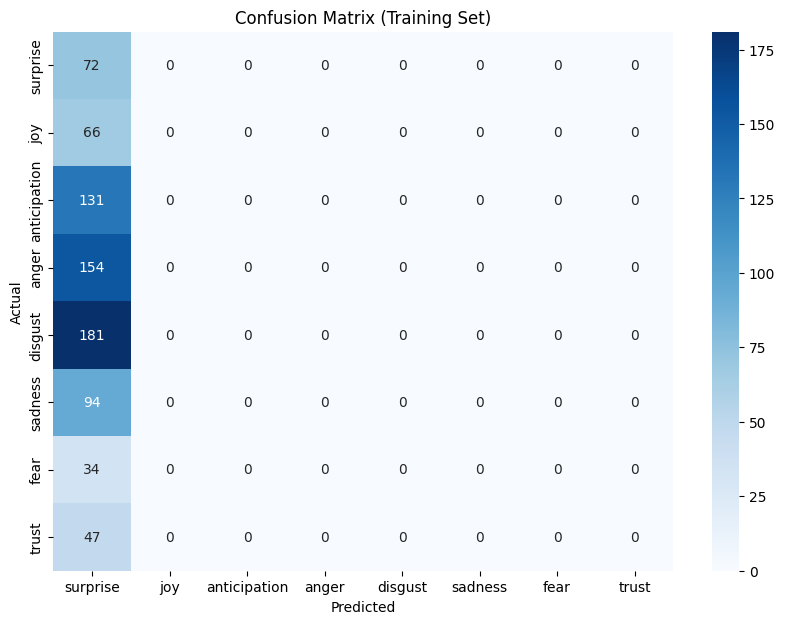

In [70]:
# Evaluate on training set
print("Training Set Evaluation")
print(f'Accuracy: {accuracy_score(y_train, train_predictions):.4f}')
print("Classification Report:\n", classification_report(y_train, train_predictions))
conf_matrix_train = confusion_matrix(y_train, train_predictions, labels=list(emotion_ranges.keys()))
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_ranges.keys(), yticklabels=emotion_ranges.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Training Set)')
plt.show()


Validation Set Evaluation
Accuracy: 0.0560
Classification Report:
               precision    recall  f1-score   support

       anger       0.00      0.00      0.00        51
anticipation       0.00      0.00      0.00        61
     disgust       0.00      0.00      0.00        61
        fear       0.00      0.00      0.00         8
         joy       0.00      0.00      0.00        25
     sadness       0.00      0.00      0.00        33
    surprise       0.06      1.00      0.11        15
       trust       0.00      0.00      0.00        14

    accuracy                           0.06       268
   macro avg       0.01      0.12      0.01       268
weighted avg       0.00      0.06      0.01       268



c:\Users\Chris\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Chris\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Chris\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

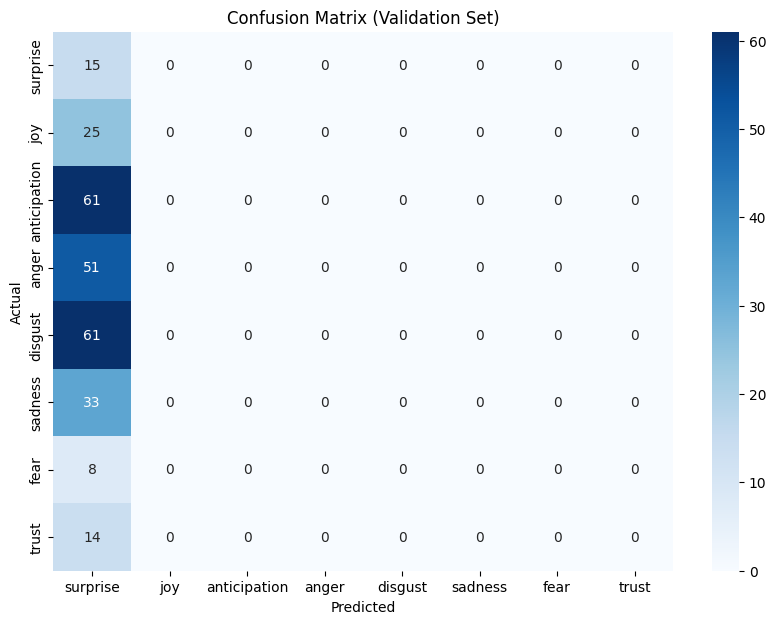

In [71]:
# Evaluate on validation set
print("Validation Set Evaluation")
print(f'Accuracy: {accuracy_score(y_val, val_predictions):.4f}')
print("Classification Report:\n", classification_report(y_val, val_predictions))
conf_matrix_val = confusion_matrix(y_val, val_predictions, labels=list(emotion_ranges.keys()))
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_ranges.keys(), yticklabels=emotion_ranges.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Validation Set)')
plt.show()

Test Set Evaluation
Accuracy: 0.0746
Classification Report:
               precision    recall  f1-score   support

       anger       0.00      0.00      0.00        20
anticipation       0.00      0.00      0.00         7
     disgust       0.00      0.00      0.00        11
        fear       0.00      0.00      0.00         3
         joy       0.00      0.00      0.00         4
     sadness       0.00      0.00      0.00        11
    surprise       0.07      1.00      0.14         5
       trust       0.00      0.00      0.00         6

    accuracy                           0.07        67
   macro avg       0.01      0.12      0.02        67
weighted avg       0.01      0.07      0.01        67



c:\Users\Chris\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Chris\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Chris\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

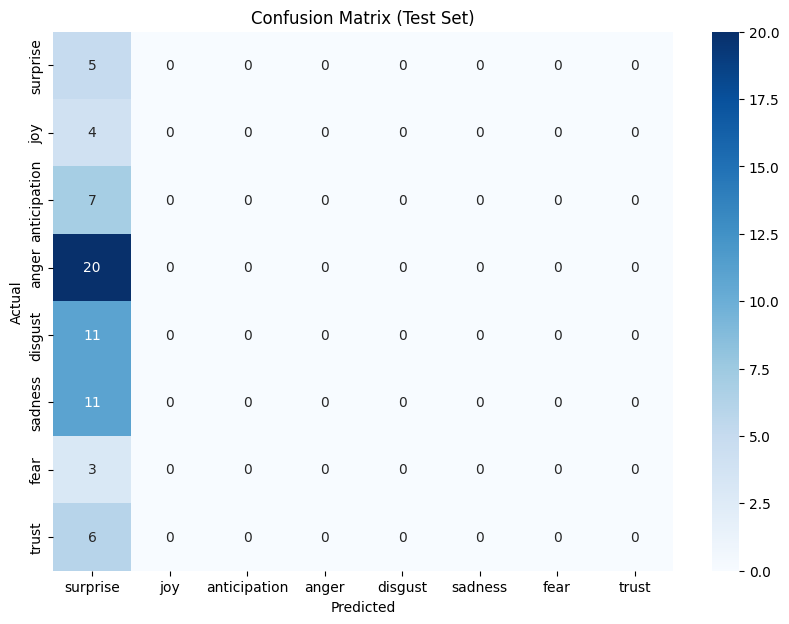

In [72]:
# Evaluate on test set
print("Test Set Evaluation")
print(f'Accuracy: {accuracy_score(y_test, test_predictions):.4f}')
print("Classification Report:\n", classification_report(y_test, test_predictions))
conf_matrix_test = confusion_matrix(y_test, test_predictions, labels=list(emotion_ranges.keys()))
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_ranges.keys(), yticklabels=emotion_ranges.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test Set)')
plt.show()